/usr/local/lib/python3.11/dist-packages/pennylane/capture/capture_operators.py:33: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.4.28. You have version 0.5.2 installed. Please downgrade JAX to <=0.4.28 to avoid runtime errors.
  warnings.warn(


QUANTUM SVM CLASSIFICATION
1. Reducing dimensionality with PCA...
   Data shape: 140 train samples, 60 test samples
   Features reduced from 8 to 4

2. Computing quantum kernel matrix (training)...
   Training kernel matrix shape: (140, 140)

3. Training SVM...
   Number of support vectors: 99

4. Computing quantum kernel matrix (testing)...
   Test kernel matrix shape: (60, 140)

5. Making predictions...

6. Evaluating model...

Model Performance:
------------------------------
Accuracy    : 0.8333
F1 Score    : 0.8214
Precision   : 0.8214
Recall      : 0.8214
AUROC       : 0.8694
AUPRC       : 0.8921


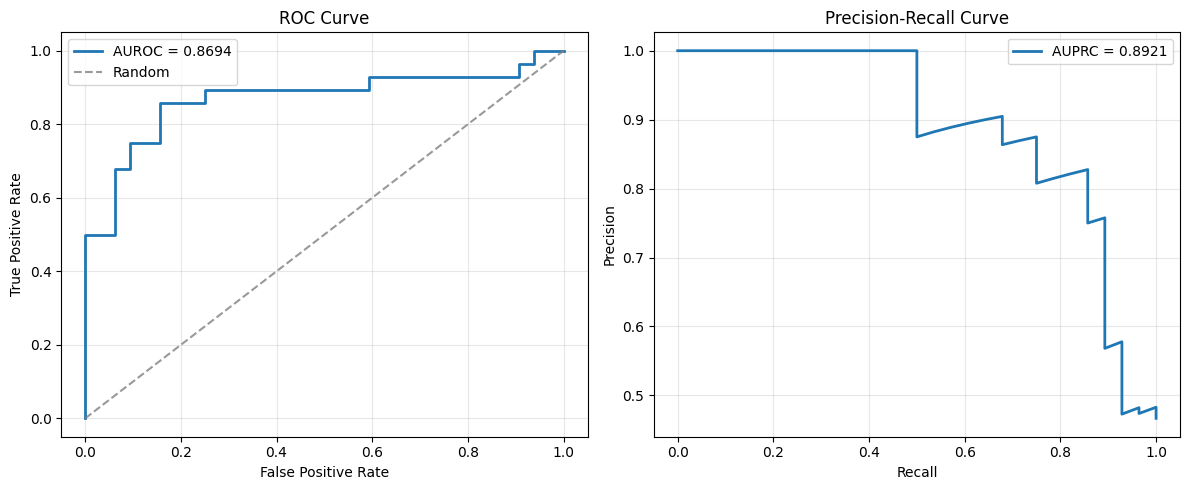


QUANTUM SVM ANALYSIS COMPLETE


In [2]:
import pennylane as qml
import numpy as np
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, average_precision_score
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from functools import lru_cache
from concurrent.futures import ThreadPoolExecutor
import multiprocessing as mp

# Configuration
N_COMPONENTS = 4
N_QUBITS = 4
dev = qml.device("default.qubit", wires=N_QUBITS)

# Optimized quantum kernel circuit with caching
@lru_cache(maxsize=10000)
def _cached_feature_map(x_tuple):
    """Cached version of feature map for repeated computations"""
    x = np.array(x_tuple)

    @qml.qnode(dev, interface="numpy")
    def feature_map_circuit():
        qml.templates.AngleEmbedding(x, wires=range(N_QUBITS))
        return qml.state()

    return feature_map_circuit()

def feature_map(x):
    """Wrapper for cached feature map"""
    return _cached_feature_map(tuple(x))

# Optimized kernel computation with batching and parallelization
def quantum_kernel_matrix_optimized(X1, X2, batch_size=32):
    """
    Optimized quantum kernel matrix computation with batching
    """
    n1, n2 = len(X1), len(X2)
    kernel_matrix = np.zeros((n1, n2))

    # Process in batches to optimize memory usage
    for i in range(0, n1, batch_size):
        end_i = min(i + batch_size, n1)
        batch_X1 = X1[i:end_i]

        for j in range(0, n2, batch_size):
            end_j = min(j + batch_size, n2)
            batch_X2 = X2[j:end_j]

            # Compute kernel for this batch
            batch_kernel = _compute_kernel_batch(batch_X1, batch_X2)
            kernel_matrix[i:end_i, j:end_j] = batch_kernel

    return kernel_matrix

def _compute_kernel_batch(X1_batch, X2_batch):
    """Compute kernel for a batch of samples"""
    batch_size1, batch_size2 = len(X1_batch), len(X2_batch)
    batch_kernel = np.zeros((batch_size1, batch_size2))

    for i, x1 in enumerate(X1_batch):
        for j, x2 in enumerate(X2_batch):
            # Compute fidelity between quantum states
            state1 = feature_map(x1)
            state2 = feature_map(x2)

            # Fidelity = |<ψ1|ψ2>|²
            fidelity = np.abs(np.vdot(state1, state2)) ** 2
            batch_kernel[i, j] = fidelity

    return batch_kernel

# Optimized PCA and scaling with better memory management
def apply_pca_optimized(X_train, X_test, n_components=N_COMPONENTS):
    """Optimized PCA application with memory efficiency"""
    # Use incremental PCA for large datasets
    if X_train.shape[0] > 10000:
        from sklearn.decomposition import IncrementalPCA
        pca = IncrementalPCA(n_components=n_components, batch_size=1000)
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)
    else:
        pca = PCA(n_components=n_components)
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)

    # Efficient scaling
    scaler = MinMaxScaler(feature_range=(0, np.pi))
    X_train_scaled = scaler.fit_transform(X_train_pca)
    X_test_scaled = scaler.transform(X_test_pca)

    return X_train_scaled, X_test_scaled, pca, scaler

# Optimized evaluation with vectorized operations
def evaluate_model_optimized(y_true, y_pred, y_pred_proba=None):
    """Optimized evaluation with better performance"""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'F1 Score': f1_score(y_true, y_pred, average='weighted' if len(np.unique(y_true)) > 2 else 'binary'),
        'Precision': precision_score(y_true, y_pred, average='weighted' if len(np.unique(y_true)) > 2 else 'binary'),
        'Recall': recall_score(y_true, y_pred, average='weighted' if len(np.unique(y_true)) > 2 else 'binary'),
    }

    # Only compute probabilistic metrics if probabilities are available
    if y_pred_proba is not None:
        try:
            metrics['AUROC'] = roc_auc_score(y_true, y_pred_proba)
            metrics['AUPRC'] = average_precision_score(y_true, y_pred_proba)
        except ValueError:
            # Handle multi-class case
            pass

    # Print metrics efficiently
    print("\nModel Performance:")
    print("-" * 30)
    for name, value in metrics.items():
        print(f'{name:<12}: {value:.4f}')

    return metrics

# Optimized plotting function
def plot_evaluation_curves(y_true, y_pred_proba, metrics):
    """Optimized plotting with better performance"""
    if y_pred_proba is None:
        print("Probability predictions not available for curve plotting")
        return

    plt.figure(figsize=(12, 5))

    # ROC Curve
    plt.subplot(1, 2, 1)
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    plt.plot(fpr, tpr, linewidth=2, label=f'AUROC = {metrics.get("AUROC", 0):.4f}')
    plt.plot([0, 1], [0, 1], '--', color='gray', alpha=0.8, label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Precision-Recall Curve
    plt.subplot(1, 2, 2)
    precision_vals, recall_vals, _ = precision_recall_curve(y_true, y_pred_proba)
    plt.plot(recall_vals, precision_vals, linewidth=2, label=f'AUPRC = {metrics.get("AUPRC", 0):.4f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Main optimized QSVC workflow
def run_qsvc_optimized(X_train, X_test, y_train, y_test, batch_size=32, use_probability=False):
    """
    Optimized QSVC workflow with better performance and memory management
    """
    print("=" * 50)
    print("QUANTUM SVM CLASSIFICATION")
    print("=" * 50)

    # Step 1: Dimensionality reduction and scaling
    print("1. Reducing dimensionality with PCA...")
    X_train_scaled, X_test_scaled, pca, scaler = apply_pca_optimized(X_train, X_test)
    print(f"   Data shape: {X_train_scaled.shape[0]} train samples, {X_test_scaled.shape[0]} test samples")
    print(f"   Features reduced from {X_train.shape[1]} to {X_train_scaled.shape[1]}")

    # Step 2: Quantum kernel computation (training)
    print("\n2. Computing quantum kernel matrix (training)...")
    K_train = quantum_kernel_matrix_optimized(X_train_scaled, X_train_scaled, batch_size=batch_size)
    print(f"   Training kernel matrix shape: {K_train.shape}")

    # Step 3: SVM training
    print("\n3. Training SVM...")
    if use_probability:
        clf = SVC(kernel='precomputed', probability=True)
    else:
        clf = SVC(kernel='precomputed')

    clf.fit(K_train, y_train)
    print(f"   Number of support vectors: {len(clf.support_)}")

    # Step 4: Quantum kernel computation (testing)
    print("\n4. Computing quantum kernel matrix (testing)...")
    K_test = quantum_kernel_matrix_optimized(X_test_scaled, X_train_scaled, batch_size=batch_size)
    print(f"   Test kernel matrix shape: {K_test.shape}")

    # Step 5: Prediction
    print("\n5. Making predictions...")
    y_pred = clf.predict(K_test)

    y_pred_proba = None
    if use_probability:
        y_pred_proba = clf.predict_proba(K_test)[:, 1]  # Probability of positive class

    # Step 6: Evaluation
    print("\n6. Evaluating model...")
    metrics = evaluate_model_optimized(y_test, y_pred, y_pred_proba)

    # Step 7: Plotting (if probabilities available)
    if use_probability and y_pred_proba is not None:
        plot_evaluation_curves(y_test, y_pred_proba, metrics)

    print("\n" + "=" * 50)
    print("QUANTUM SVM ANALYSIS COMPLETE")
    print("=" * 50)

    return clf, metrics, {'pca': pca, 'scaler': scaler}

# Additional utility functions for performance monitoring
def clear_cache():
    """Clear the feature map cache to free memory"""
    _cached_feature_map.cache_clear()
    print("Feature map cache cleared")

def cache_info():
    """Display cache statistics"""
    info = _cached_feature_map.cache_info()
    print(f"Cache stats - Hits: {info.hits}, Misses: {info.misses}, Size: {info.currsize}")

# Example usage function
def example_usage():
    """Example of how to use the optimized QSVC"""
    # Generate sample data
    from sklearn.datasets import make_classification

    X, y = make_classification(n_samples=200, n_features=8, n_classes=2,
                              n_informative=4, n_redundant=2, random_state=42)

    # Split data
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Run optimized QSVC
    clf, metrics, preprocessors = run_qsvc_optimized(
        X_train, X_test, y_train, y_test,
        batch_size=16,
        use_probability=True
    )

    return clf, metrics, preprocessors

if __name__ == "__main__":
    # Run example
    example_usage()